### pip install & import

In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflowjs as tfjs
import pandas as pd
#import pandas_profiling
import datetime

In [3]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


import kerastuner as kt

C:\Users\Playdata\AppData\Local\Temp\ipykernel_13704\3242300264.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

# from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_validate

### 최종데이터 불러오기

In [5]:
movie_final = pd.read_csv('../3_merge_top300/movie_final.csv',encoding='utf-8')

## 원핫인코딩 

In [6]:
# 원핫인코딩

# movie_labels = pd.get_dummies(movie_final,columns = ['국적','장르','등급','계절'])

In [7]:
# 독립 변수와 종속 변수 나눔

# 독립 = movie_DL[['감독_흥행', '배급사_흥행', '국적_기타', '국적_독일', '국적_미국',
#        '국적_영국', '국적_일본', '국적_중국', '국적_프랑스', '국적_한국', '장르_SF', '장르_가족', '장르_공연',
#        '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬',
#        '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_성인물(에로)', '장르_스릴러',
#        '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_판타지',
#        '등급_12세관람가', '등급_15세관람가', '등급_전체관람가', '등급_청소년관람불가', '계절_가을', '계절_겨울',
#        '계절_봄', '계절_여름']] 
# 종속 = movie_DL[['전국 관객수']] 

## 라벨링

In [8]:
from sklearn.preprocessing import LabelEncoder

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()

movie_labels = movie_final.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final['계절'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.head(3)


,순번,영화명,감독,배급사,개봉일,영화형태,국적,전국 스크린수,전국 매출액,전국 관객수,...,영화구분,연도,월,계절,총 관객수,출연,평점,감독_흥행,배급사_흥행,주연배우_흥행
0,25,아바타: 물의 길,제임스 카메론,월트디즈니스튜디오스코리아,2022-12-14,2,2,2809,137325939643,10779198,...,1,2022,12,1,112805094,"['시고니 위버', '스티븐 랭', '조 샐다나', '샘 워싱턴', '우나 채플린'...",8.65,0,10,10
1,26,어벤져스: 에이지 오브 울트론,조스 웨던,월트디즈니스튜디오스코리아,2015-04-23,2,2,1843,88582586366,10494499,...,1,2015,4,2,217299523,"['로버트 다우니 주니어', '크리스 헴스워스', '마크 러팔로', '크리스 에반스...",8.32,9,10,76
2,27,기생충,봉준호,씨제이이엔엠,2019-05-30,2,7,1948,87459829095,10313086,...,1,2019,5,2,226678777,"['송강호', '이선균', '조여정', '최우식', '박소담', '이정은', '장혜진']",8.49,10,10,26


In [9]:
movie_labels[['전국 관객수']].describe().round(0)

,전국 관객수
count,3105.0
mean,697632.0
std,1377598.0
min,2212.0
25%,33469.0
50%,131124.0
75%,636631.0
max,10779198.0


### 데이터분배
1) movie_labels_etc : train과 val data   
2) movie_labels_2023 : test data

In [10]:
movie_labels_2023 = movie_labels[movie_labels['연도']==2023]
movie_labels_etc = movie_labels[movie_labels['연도']!=2023]

### 변수 정리   
1. 사용하지 않는 컬럼 제거
2. 독립변수와 종속변수 설정

In [11]:
# 사용하지 않는 컬럼 제거

not_used = ['영화명', '감독', '배급사', '영화형태', '개봉일', '영화구분', '연도', '월']

movie_DL = movie_labels_etc.drop(not_used, axis=1) # 2003~2022 데이터 main
movie_DL2 = movie_labels_2023.drop(not_used, axis=1)# 2023년 test


In [12]:
# 국적 => 국내 vs 해외
# 관객비율.. 2023년 데이터 총 관객수 몰라....
# 비율 말고 총 관객수를 쓰자
# 총관객수 defqult를 2022년으로 해서 2023년 총관객수 채우면 어때?

In [13]:
# 독립 변수와 종속 변수 나눔

독립 = movie_DL[['장르', '등급', '감독_흥행','총 관객수',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수']]
종속 = movie_DL[['전국 관객수']]

In [14]:
# 독립 변수와 종속 변수 나눔

독립_2023 = movie_DL2[['장르', '등급', '감독_흥행','총 관객수',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수']]
종속_2023 = movie_DL2[['전국 관객수']]


In [15]:
종속 = movie_DL[['전국 관객수']].copy()
종속['전국 관객수'] = 종속['전국 관객수'] / 1000 

종속_2023 = movie_DL2[['전국 관객수']].copy()
종속_2023['전국 관객수'] = 종속_2023['전국 관객수'] / 1000 


독립 = movie_DL[['장르', '등급', '감독_흥행','총 관객수',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수']].copy()
독립['총 관객수'] = 독립['총 관객수'] / 1000 

독립_2023 = movie_DL2[['장르', '등급', '감독_흥행','총 관객수',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수']].copy()
독립_2023['총 관객수'] = 독립_2023['총 관객수'] / 1000

## train, test 데이터 나누기

In [16]:
# train, test 데이터 나눔

from sklearn.model_selection import train_test_split
train_input, test_input, train_target,test_target = train_test_split(독립,종속,test_size=0.25,random_state=42)

In [33]:
train_input.columns

Index(['장르', '등급', '감독_흥행', '총 관객수', '배급사_흥행', '주연배우_흥행', '계절', '전국 스크린수'], dtype='object')

## 스케일링... 
...어디서 할까...<br>
라벨링 때문에 바로 스케일링을 따로 해줘야함 (전국스크린수, 총 관객수)

In [34]:
# 값 스케일링

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [ ]:
train_input

In [35]:
from sklearn.preprocessing import RobustScaler

# 객체생성
robust_scaler = RobustScaler()

# *** 만약 특정 열의 스케일링을 하고 싶은 경우 ***
A_n = robust_scaler.fit_transform(train_input['전국 스크린수'].values.reshape(-1,1))
train_input.insert(0, '전국 스크린수_1', A_n)
train_input.drop(['전국 스크린수'], axis=1, inplace=True)

A_n1 = robust_scaler.fit_transform(train_input['총 관객수'].values.reshape(-1,1))
train_input.insert(0, '총 관객수_1', A_n1)
train_input.drop(['총 관객수'], axis=1, inplace=True)

In [49]:
A_n = robust_scaler.fit_transform(독립_2023['전국 스크린수'].values.reshape(-1,1))
독립_2023.insert(0, '전국 스크린수_1', A_n)
독립_2023.drop(['전국 스크린수'], axis=1, inplace=True)

A_n1 = robust_scaler.fit_transform(독립_2023['총 관객수'].values.reshape(-1,1))
독립_2023.insert(0, '총 관객수_1', A_n1)
독립_2023.drop(['총 관객수'], axis=1, inplace=True)

In [ ]:
train_input

### tunner를 이용한 하이퍼파라미터 찾기

해야할일 : 우리 모델에 맞는 뉴런 수, 활성화 함수 , learning rate, batch_size를 찾아야한다.

In [ ]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    # units_1 => 뉴런 갯수를 조정하는 부분
    # dropout_1 => dropout 부분을 조정하는 부분
    hp_units1 = hp.Int('units_1', min_value = 16, max_value = 180)
    hp_units2 = hp.Int('units_2', min_value = 16, max_value = 180)
    hp_units4 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)
    hp_units5 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)


    # 현재 레이어 층은
    # 입력층 > 히든층 > 출력층으로 되어있다.
    model = keras.Sequential()
    
    #입력층
    model.add(layers.Dense(hp_units1, activation='swish', input_shape=[9]))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units4))
    
    # 히든층
    model.add(layers.Dense(hp_units2, activation='swish'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units5))
    
    # 출력층
    model.add(layers.Dense(1, activation='swish'))

    # 1. learning rate 범위 설정
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3)
    # 2. 옵티마이저 설정
    # Choice를 통해 값을 선택에서 받음
    # hp.int을 쓰면 정수값, hp.Float를 쓰면 소수값, hp.Choice를 쓰면 선택해서
    # Adam
    Adam = optimizers.Adam(learning_rate=hp_learning_rate,beta_1=hp.Choice('beta_1',[.9,.8,.7,.6,.5]),beta_2=hp.Choice('beta_2',[.99,.88,.77,.66,.55]))
    # SGD 
    SGD = optimizers.SGD(learning_rate=hp_learning_rate,momentum=hp.Choice('momentum',[.9,.8,.7,.6,.5]))
    # 나머지 추가해야함

    model.compile(optimizer=SGD, loss='mae')
    return model
  
  # 배치사이즈 설정
  def fit(self, hp, model, *args, **kwargs):
      return model.fit(
          *args,
          batch_size=hp.Int('batch_size', min_value = 16, max_value = 256, step = 16),
          **kwargs,
      )

In [ ]:
tuner = kt.Hyperband(MyHyperModel(),
                    objective = 'loss',
                    max_epochs = 100,
                    executions_per_trial = 3,
                    overwrite = True,
                    factor = 3)

tuner.search(train_input,train_target, epochs = 100, validation_split = 0.1)

In [ ]:
# 최적 하이퍼파라미터를 가져옵니다.
best_hps = tuner.get_best_hyperparameters()[0]



# 최적 하이퍼파라미터를 출력합니다.
print(f"""
units_1 : {best_hps.get('units_1')}
units_2 : {best_hps.get('units_2')}
dropout_1 : {best_hps.get('dropout_1')}
dropout_2 : {best_hps.get('dropout_2')}
learning_rate : {best_hps.get('learning_rate')}
batch_size : {best_hps.get('batch_size')}
momentum : {best_hps.get('momentum')}
""")

In [ ]:
# 배치 크기는 따로 저장했다가 fit 메소드에서 적용합니다.
batch_size = best_hps.get('batch_size')



# 최적값으로 모델을 생성합니다.
model = tuner.hypermodel.build(best_hps)


In [ ]:
model.summary()

In [ ]:
# 훈련

model.fit(train_scaled,train_target,batch_size=batch_size,epochs=100,validation_data=(test_scaled,test_target))

# 딥러닝 


In [17]:
# 딥러닝 층 여기가 중요

X = tf.keras.layers.Input(shape=[8])

H = tf.keras.layers.Dense(512)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu)(H)

H = tf.keras.layers.Dense(256)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu)(H)

Y = tf.keras.layers.Dense(1)(H)
model = tf.keras.models.Model(X,Y)
# sgd = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.8,beta_2=0.855)
sgd = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,clipnorm=0.5,clipvalue=0.8)
model.compile(optimizer=sgd,loss='mae')

In [18]:
# 훈련

history = model.fit(train_input,train_target,batch_size=128,epochs=200,validation_data=(test_input,test_target))

Epoch 1/200
19/19 [==============================] - 2s 23ms/step - loss: 686.7474 - val_loss: 709.6404
Epoch 2/200
19/19 [==============================] - 0s 10ms/step - loss: 679.2682 - val_loss: 700.8098
Epoch 3/200
19/19 [==============================] - 0s 9ms/step - loss: 671.1103 - val_loss: 699.0837
Epoch 4/200
19/19 [==============================] - 0s 11ms/step - loss: 663.5821 - val_loss: 699.5114
Epoch 5/200
19/19 [==============================] - 0s 8ms/step - loss: 655.8294 - val_loss: 699.4240
Epoch 6/200
19/19 [==============================] - 0s 8ms/step - loss: 647.3449 - val_loss: 699.2415
Epoch 7/200
19/19 [==============================] - 0s 9ms/step - loss: 634.8428 - val_loss: 698.8796
Epoch 8/200
19/19 [==============================] - 0s 9ms/step - loss: 619.4932 - val_loss: 689.4083
Epoch 9/200
19/19 [==============================] - 0s 11ms/step - loss: 605.9875 - val_loss: 679.0383
Epoch 10/200
19/19 [==============================] - 0s 8ms/step - l

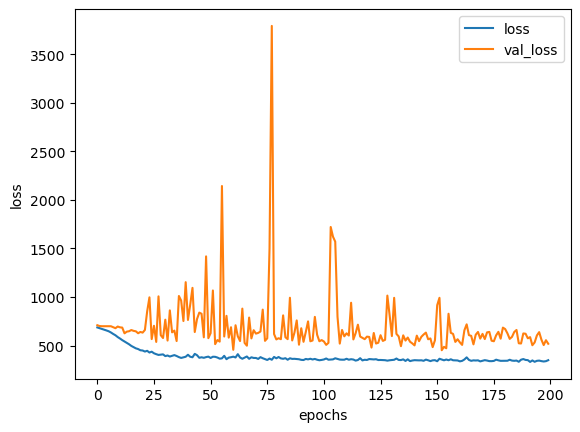

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [21]:
# 확인용도
model.predict(test_input[:5])

1/1 [==============================] - 0s 190ms/step


array([[102.76228 ],
       [ 64.47698 ],
       [ 65.083115],
       [561.3812  ],
       [548.1748  ]], dtype=float32)

In [22]:
# 여기랑 비슷한지 보기
test_target[:5]

,전국 관객수
2724,18.022
2062,53.175
2553,23.586
194,2949.944
240,2583.294


### test data 확인용도

In [23]:
# 확인용도

# 오차율 몇 %로...?
pred = model.predict(독립_2023).round(0)
# 여기랑 비슷한지 보기
종속_2023 = 종속_2023.copy() ## 복사해서 사용
종속_2023['pred'] = pred
종속_2023['오차율'] = (abs(종속_2023['전국 관객수'] - 종속_2023['pred'])) / 종속_2023['전국 관객수'] * 100
len(종속_2023.loc[종속_2023['오차율']<20])

1/1 [==============================] - 0s 28ms/step


1

In [27]:
독립_2023

,장르,등급,감독_흥행,총 관객수,배급사_흥행,주연배우_흥행,계절,전국 스크린수
378,6,0,6,112805.094,9,20,1,1289
465,16,0,8,112805.094,10,32,1,2090
670,15,2,0,112805.094,9,16,1,924
755,16,1,8,112805.094,10,25,1,1099
1009,4,0,0,112805.094,10,20,1,912
1071,6,1,0,112805.094,0,0,1,699
1188,6,0,0,112805.094,10,20,1,946
1240,9,0,0,112805.094,10,9,1,868
1265,3,1,0,112805.094,9,0,1,704
1355,6,3,6,112805.094,10,8,1,852


In [26]:
tfjs.converters.save_keras_model(model,'saved_model')